In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/IWS/Delivery/")

Mounted at /content/drive


## Load the data 

In this work, we try to use all the H2S data as the labels, the Flow, pH, ORP, temp (15 minutes), rainfall, total solids, ss, BOD5, NH3, Org-N, and SO4 (daily) as training data.
We then open the Excel file directly. It will take a minute or two to open the file.
H2S will be used as the labels.

In [ ]:
import pandas as pd
r = 'Model 2 data.xlsx'
H2S = pd.read_excel(r,sheet_name='H2S data', index_col='Date')

In [ ]:
H2S.drop('Time',inplace=True,axis=1)
H2S.drop('DateTime',inplace=True,axis=1)
H2S.head()

,H2S_ppm
Date,
2017-07-14,0
2017-07-14,0
2017-07-14,0
2017-07-14,0
2017-07-14,0


We need to find out the daily maximum:

In [ ]:
H2S_daily_max = H2S.groupby(pd.Grouper(freq='D')).max()
H2S_daily_max.dropna(inplace=True)
H2S_daily_max.iloc[-1]

H2S_ppm    39.0
Name: 2019-08-22 00:00:00, dtype: float64

We will now load the flow, ORP, pH, temp, and NOOA data:

In [ ]:
# Orp, pH, temp, flow, tunnel_elev_ft
data = pd.read_excel(r,sheet_name='15min data', index_col='date_time',parse_dates=True)
data_daily_max = data.groupby(pd.Grouper(freq='D')).max()

# Rainfall data
r = 'Rainfall data.xlsx'
rf = pd.read_excel(r,sheet_name='Daily',index_col='DATE')
rf.drop(['PRCP_KWRP'],inplace=True,axis=1)

data_daily_max = data_daily_max.join(rf,how='inner')


/usr/local/lib/python3.6/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname D identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/usr/local/lib/python3.6/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname S identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [ ]:
data_daily_max.iloc[-1]

flow_mgd             91.3
tunnel_elev_ft      8.689
ORP_mV              227.2
pH                    7.2
temp_F                 74
tunnel_pumping          0
CUP                no-cup
TUNNEL VOL (MG)       NaN
PRCP_NOOA             1.4
Name: 2019-08-26 00:00:00, dtype: object

In [ ]:
joined_data = H2S_daily_max.join(data_daily_max,how='inner')
# joined_data = joined_data.join(tunnel_level_max,how='inner')

# # Generate switch
# switch = []
# switch_value = 0
# for value in joined_data['tunnel_elev_ft']:
#     if switch_value == 0 and value <= 40:
#         switch.append(switch_value)
#     elif switch_value == 0 and value > 40:
#         switch_value = 1
#         switch.append(switch_value)
#     elif switch_value == 1 and value > 5:
#         switch.append(switch_value)
#     elif value <= 5:
#         switch_value = 0
#         switch.append(switch_value)
        
# assert(len(switch) == len(joined_data['tunnel_elev_ft']))

# # Tunnel level: previous - current
tunnel_level = joined_data['tunnel_elev_ft'].values[:-1]-joined_data['tunnel_elev_ft'].values[1:]

# switch.pop(-1)

joined_data = joined_data.drop(joined_data.index[-1])

# joined_data['switch'] = switch
joined_data['tunnel_elev_ft'] = tunnel_level
joined_data.iloc[-1]

H2S_ppm                20
flow_mgd             42.8
tunnel_elev_ft      1.743
ORP_mV             -318.9
pH                    7.2
temp_F                 81
tunnel_pumping          0
CUP                no-cup
TUNNEL VOL (MG)       NaN
PRCP_NOOA            0.02
Name: 2019-08-21 00:00:00, dtype: object

We now deal with the waste water data (total solids, ss, etc.):

In [ ]:
import numpy as np
###r = 'Water Quality Analysis Data_composite and grab samples.xlsx'
###ww_data = pd.read_excel(r,sheet_name='raw_sewage', header=2)

r = 'Water-Quality-Analysis-Data.xlsx'
ww_data = pd.read_excel(r,sheet_name='raw_sewage', header = 3, index_col='Date')

#ww_data = ww_data.apply(lambda x: np.nan if x.dtype == str else x)

# Drop the units
###ww_data.drop(['Date'],inplace=True, axis=0)

# Drop Temp, pH, ORP, SO3 VFA, orthoP SO4-
ww_data.drop(['Temp','pH','ORP','SO3','VFA','orthoP','SO4-'],inplace=True, axis=1)

# Replace white spaces with nan
ww_data['SO4'][ww_data['SO4'] == '     '] = np.nan
ww_data['SO4'][ww_data['SO4'] == '       '] = np.nan

ww_data['SO4'] = ww_data['SO4'].interpolate()

# Fill NA
ww_data.fillna(method='backfill',inplace=True)

# Join
joined_data = joined_data.join(ww_data,how='inner')
joined_data.dropna(inplace=True)
joined_data.iloc[-1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


H2S_ppm                   0
flow_mgd              118.6
tunnel_elev_ft       10.334
ORP_mV                234.3
pH                        7
temp_F                   57
tunnel_pumping            0
CUP                emptying
TUNNEL VOL (MG)          70
PRCP_NOOA                 0
Total Solids            600
SS                       27
BOD5                     28
NH3                    5.19
Org-N                   2.6
TKN                    7.82
P-TOT                  1.07
SO4                      93
Name: 2019-05-10 00:00:00, dtype: object

In [ ]:
joined_data['H2S_ppm'].describe()

count     70.000000
mean       5.042857
std       17.952785
min        0.000000
25%        0.000000
50%        0.000000
75%        1.750000
max      140.000000
Name: H2S_ppm, dtype: float64

In [ ]:
# max is 140
H2S_values = joined_data['H2S_ppm'].values

In [ ]:
# Level defines the number of classes
level = 10
Max = 140
levels = Max//level
labels = []
for h2s in H2S_values:
    if h2s == 0:
        labels.append(0)
    elif h2s <= 5:
        labels.append(1)
    elif h2s <= 10:
        labels.append(2)
    else:
        for i in range(2,levels+1):
            if h2s <= i*level:
                labels.append(i+1)
                break;

In [ ]:
# Make the labels list into a Series for the histogram
s_labels = pd.Series(labels)

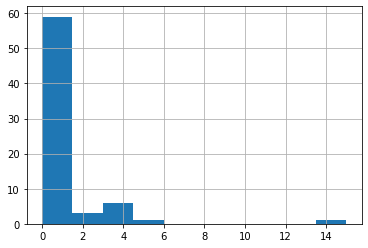

In [ ]:
%matplotlib inline
s_labels.hist()

We need random oversampling to solve the imbanlanaced dataset problem

In [ ]:
train_data = (joined_data.drop('H2S_ppm',axis=1)).drop(['TUNNEL VOL (MG)','CUP'],axis=1).values
import sys
###sys.path.append("/home/xing/anaconda3/envs/keras/lib/python3.6/site-packages")
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
ros = RandomOverSampler(random_state=0)
#ada = ADASYN(random_state=43, n_neighbors=4)
X_resampled, y_resampled = ros.fit_resample(train_data, s_labels.values)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After the random oversampling, each class now has same amount of data.
However, if the level is set to be 10, class 11 will have no data:

In [ ]:
from collections import Counter
sampling_info = sorted(Counter(y_resampled).items())
print(sampling_info)
y_resampled.size

[(0, 40), (1, 40), (2, 40), (3, 40), (4, 40), (5, 40), (15, 40)]


280

## Data normalization:

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_resampled)
X_normalized = scaler.transform(X_resampled)
X_normalized.shape

(280, 15)

## Data sampling (train v.s. test)

In [ ]:
jump = sampling_info[0][1]# jump should be the amount of data under each class
split = 0.2
test_amount = int(jump*split)

seed = 43
np.random.seed(seed=seed)
test_indices = []

# 7 is the number of classes
for i in range(7):
    test_indices += list(np.random.choice(np.arange(i*jump,(i+1)*jump),size=test_amount, replace=False))
    
assert(len(test_indices) == (7)*test_amount)
assert(len(set(test_indices)) == len(test_indices))

In [ ]:
train_indices = list(set(np.arange(len(y_resampled))).difference(set(test_indices)))
train_data, train_labels = X_resampled[train_indices], y_resampled[train_indices]
test_data, test_labels = X_resampled[test_indices], y_resampled[test_indices]

In [ ]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((224, 15), (224,), (56, 15), (56,))

## Classification

In [ ]:
# Try to remove outliers
# from sklearn.ensemble import IsolationForest
# from imblearn import FunctionSampler

# rng = np.random.RandomState(seed)
# def outlier_rejection(X, y):
#     """This will be our function used to resample our dataset."""
#     model = IsolationForest(max_samples=100,
#                             contamination=0.4,
#                             random_state=rng)
#     model.fit(X)
#     y_pred = model.predict(X)
#     return X[y_pred == 1], y[y_pred == 1]

# reject_sampler = FunctionSampler(func=outlier_rejection)
# train_data, train_labels = reject_sampler.fit_resample(train_data, train_labels)
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=seed)
param_grid = [{'n_estimators': [50,100], 'max_features':[4,6,8,10,15], 'bootstrap': [False]}]
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', return_train_score=True, n_jobs=-1)
grid_search.fit(train_data, train_labels)

best_rf = grid_search.best_estimator_

print(best_rf)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=43, verbose=0,
                       warm_start=False)


In [ ]:
predictions = best_rf.predict(test_data)
print(classification_report(test_labels, predictions))
print("Accuracy: %.2f%%"%((predictions==test_labels).sum()/test_labels.size*100))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.91      0.91      0.91        11
           2       1.00      1.00      1.00         7
           3       0.88      1.00      0.93         7
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00         9
          15       1.00      1.00      1.00         8

    accuracy                           0.96        56
   macro avg       0.97      0.95      0.96        56
weighted avg       0.97      0.96      0.96        56

Accuracy: 96.43%


In [ ]:
# Attribute importance
d = dict(zip(joined_data.drop(['H2S_ppm','TUNNEL VOL (MG)', 'CUP'],axis=1).columns.values.tolist(),best_rf.feature_importances_))
import operator
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_d)

[('flow_mgd', 0.17662383941775167), ('Total Solids', 0.15454621427740084), ('SS', 0.1390029613024505), ('BOD5', 0.0888096654939087), ('TKN', 0.06923430535981849), ('temp_F', 0.06774321839901833), ('tunnel_elev_ft', 0.06615588825152882), ('Org-N', 0.0577071925357156), ('P-TOT', 0.05330526821359731), ('PRCP_NOOA', 0.04641475432994888), ('ORP_mV', 0.03983268150670102), ('NH3', 0.0161499023147338), ('SO4', 0.014959531048032888), ('pH', 0.009514577549393244), ('tunnel_pumping', 0.0)]


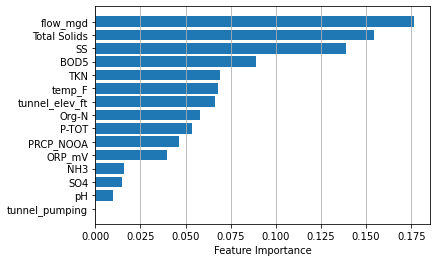

In [ ]:
#bar plot for feature importance
import matplotlib.pyplot as plt
scores = []
Vars = []
for k,v in sorted_d[::-1]:
    scores.append(v)
    Vars.append(k)
plt.barh(np.arange(len(scores)), scores,align='center')
plt.yticks(np.arange(len(scores)), Vars)
plt.xlabel('Feature Importance')
plt.grid(True,axis='x')
plt.show()

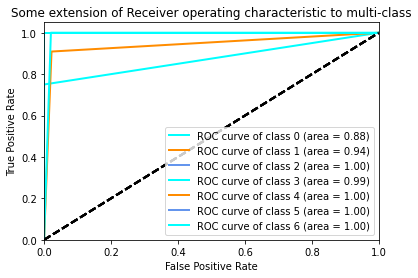

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
labels = [k for k,v in sorted(Counter(y_resampled).items())]
predictions = label_binarize(predictions,classes=labels)

test_labels_copy = label_binarize(test_labels,classes=labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_copy[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
lw=2
for i, color in zip(range(len(labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()    

Let's try SVM:

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
score = 'accuracy'
grid_search = GridSearchCV(SVC(random_state=seed), tuned_parameters, cv=5,
                   scoring= score, n_jobs=-1)
grid_search.fit(train_data, train_labels)
best_svm = grid_search.best_estimator_
print(best_svm)
predictions = best_svm.predict(test_data)
print(classification_report(test_labels, predictions))
print("Accuracy: %.2f%%"%((predictions==test_labels).sum()/test_labels.size*100))

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=43, shrinking=True, tol=0.001,
    verbose=False)
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.91      0.95        11
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00         9
          15       1.00      1.00      1.00         8

    accuracy                           0.98        56
   macro avg       0.97      0.99      0.98        56
weighted avg       0.99      0.98      0.98        56

Accuracy: 98.21%


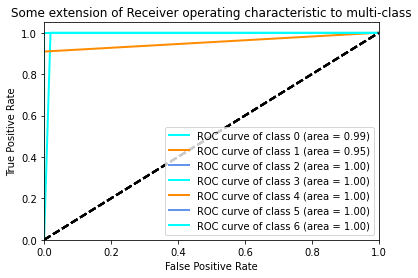

In [ ]:
labels = [k for k,v in sorted(Counter(y_resampled).items())]
predictions = label_binarize(predictions,classes=labels)

test_labels_copy = label_binarize(test_labels,classes=labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_copy[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
lw=2
for i, color in zip(range(len(labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()    